# Quantifying the Criticism of #BlackLivesMatter

**Key Topics: Social Media Analysis; Social Movements; Natural Language
Processing**

Welcome! We will now apply the concepts we introduced in the slides to demonstrate how to complete a data science project from start to finish. 

Since last summer, the #BlackLivesMatter movement has been front and center in the US, and has often garnered criticism for the nature of rhetoric it uses (quoted by critics as 'revolutionary' and 'inflammatory). It has also spawned counter movements, such as #WhiteLivesMatter, #AllLivesMatter, and #BlueLivesMatter. 

We decided to explore this.

We used Twitter data to gather the rhetoric around the 4 movements mentioned above. Our choice was influenced by how social media platforms like Twitter are a great place for activists to document their activity and opinions. Therefore, for this demo, we decided use tweets gathered using the [Twint](https://pypi.org/project/twint/) web interface. Hashtags are used to indicate that the tweet comes from a supporter of a particular social movement. The time period spans the week after the murder of [George Floyd](https://en.wikipedia.org/wiki/George_Floyd), 25 May 2020 - 1 June 2020.

Twint may be a better alternative to the standard Twitter API, which places limitations on the volume of data and the speed at which it can be collected. Twint is a powerful source and takes a while to run, so if you plan to gather historical data spanning a week or longer, we suggest creating smaller datasets for each week then concatenating them into one big dataset to avoid notebook errors and losing progress. 


We also calculate the polarity of each tweet as a proxy for the positive/negative connotations carried by it. A tweet with a polarity of +1 is strongly positive, -1 is strongly negative, and 0 is neutral. More on how we calculate this in Step 3 in the notebook.

#### ***Step 1. Find a dataset***

*Special shoutout to Michela Burns for introducing us to Twint and giving us a tutorial on how to use it.*  

**A. Install Twint.**<br>
```
pip install --upgrade git+https://github.com/twintproject/twint.git@origin/master#egg=twint
```

**B. Install TextBlob for NLP.**<br>
```
pip install -U textblob
```

**C. Import necessary libraries.**<br>
```
import twint
from textblob import TextBlob
import pandas as pd
import numpy as np
import datetime
import time
import re
import nest_asyncio
```

**D. Prevent notebook issues from occurring while runnign Twint.**<br>
```
nest_asyncio.apply()
```

**E. Configure the Twint API**<br>
```
config = twint.Config()
```

**F. Set the parameters/attributes you want within the tweets. Note: For more configuration options, explore the wiki page - https://github.com/twintproject/twint/wiki/Configuration. **<br>
```
config.Store_object = True
config.Lang = 'en' #Only tweets written in English
config.Since = "2020-05-25" #Start getting the tweets (inclusive)
config.Until = "2020-06-02" #Stop getting the tweets (exclusive)
config.Search = "#BlackLivesMatter" #Hashtag you're searching for
config.Pandas = True
```
   
**G. Run Twint**<br>
```
twint.run.Search(config)

tweets_df = twint.storage.panda.Tweets_df
tweets_df.head()
```

**H. Download the data as a csv and save it to Google Drive.**<br>
*Enter the authentication code from the URL after running this cell:*<br>
```
from google.colab import drive
drive.mount('drive')
```
*Run this next:*<br>
```
tweets_df.to_csv('tweets_df.csv')
!cp tweets_df.csv "drive/My Drive/"
```

**I. Upload the data to Deepnote and read it into the notebook.**<br>
```
tweets_df = pd.read_csv('/work/data/tweets_df.csv')
```

______
#### ***Step 2. Data Cleaning***

**A. Apply the cleaning methods to the dataframe at once using a function. Note: You can do this one by one, without a function, but it's slower.**<br>
```
def clean_txt(text):
    text = re.sub(r"(?:\@)\S+", "", text) #Removing @mentions
    text = re.sub('#', '', text) #Removing '#' hash tag
    text = re.sub('RT[\s]+', '', text) #Removing RT
    text = re.sub('https?:\/\/\S+', '', text) #Removing hyperlink
    text = text.strip() #Removing leading and trailing spaces 
    text = text.lower() #Make tweet text lowercase
    return text

tweets_df['clean_tweet'] = tweets_df['tweet'].apply(clean_txt)
tweets_df.head()
```

**The next cell reads in our dataset, created by combining the tweets for each social movement and selecting the features we may want to work with.**

In [ ]:
import pandas as pd
import numpy as np
combined = pd.read_csv("/work/data/combined.csv", usecols=[0,1,2,3,4,5,6,7])
combined

date  \
0       2020-06-01 20:31:00   
1       2020-06-01 20:30:28   
2       2020-06-01 20:30:21   
3       2020-06-01 20:30:12   
4       2020-06-01 20:29:57   
...                     ...   
215750  2020-05-25 15:50:25   
215751  2020-05-25 14:03:53   
215752  2020-05-25 11:10:24   
215753  2020-05-25 05:37:48   
215754  2020-05-25 05:23:48   

                                                    tweet  \
0       #Anonymuos DIFUNDAN!!!!!!!!! #AllLivesMatter #...   
1       @mbstra No I do not as I think many sentencing...   
2       #BlackLivesMatter #AllLivesMatter  court case ...   
3       To make George #Floyd's death matter, people m...   
4       The importance of ✊ #BLACK_LIVES_MATTER, and t...   
...                                                   ...   
215750          @7rrings white pride 😌💕 #whitelivesmatter   
215751  Sorry..... #whitelivesmatter  https://t.co/VlT...   
215752  Nobody cares about Black on White violence bec...   
215753  @lostinacanyon @yojnagem @William54076389 @Bal...   
215754  @stonecold2050 Ahmaud Arbery Murder   William ...   

                                                 hashtags  nlikes  nreplies  \
0       ['anonymuos', 'alllivesmatter', 'justiceforflo...      10         0   
1                   ['alllivesmatter', 'bluelivesmatter']       0         1   
2       ['blacklivesmatter', 'alllivesmatter', 'emoryu...       0         0   
3       ['floyd', 'justiceforgeorgefloyd', 'alllivesma...       0         0   
4                ['black_lives_matter', 'alllivesmatter']       1         0   
...                                                   ...     ...       ...   
215750                               ['whitelivesmatter']       1         0   
215751                               ['whitelivesmatter']       0         0   
215752  ['itsokaytobewhite', 'antiwhite', 'whitelivesm...       1         0   
215753  ['ahmaudarbery', 'irunwithmaud', 'blacklivesma...       1         0   
215754  ['ahmaudarbery', 'irunwithmaud', 'blacklivesma...       0         0   

        nretweets             search  \
0               5    #AllLivesMatter   
1               0    #AllLivesMatter   
2               0    #AllLivesMatter   
3               0    #AllLivesMatter   
4               0    #AllLivesMatter   
...           ...                ...   
215750          0  #WhiteLivesMatter   
215751          0  #WhiteLivesMatter   
215752          0  #WhiteLivesMatter   
215753          0  #WhiteLivesMatter   
215754          0  #WhiteLivesMatter   

                                              clean_tweet  
0       anonymuos difundan!!!!!!!!! alllivesmatter jus...  
1       no i do not as i think many sentencing laws ar...  
2       blacklivesmatter alllivesmatter  court case ag...  
3       to make george floyd's death matter, people mu...  
4       the importance of ✊ black_lives_matter, and th...  
...                                                   ...  
215750                    white pride 😌💕 whitelivesmatter  
215751                        sorry..... whitelivesmatter  
215752  nobody cares about black on white violence bec...  
215753  how do you think murder suspect william bryan ...  
215754  ahmaud arbery murder   william bryan charged, ...  

[215755 rows x 8 columns]

___
#### ***Step 3. Exploratory Data Analysis and Visualizations***

**A. Calculate the polarity and subjectivity scores for each tweet using TextBlob.**
```
def analyze_sentiment(row):
    tb = TextBlob(row.clean_tweet)

    #Polarity: Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement.
    row['polarity'] = tb.sentiment.polarity

    #Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. 
    #Subjectivity is also a float which lies in the range of [0,1]
    row['subjectivity'] = tb.sentiment.subjectivity
    
    return row


tweets_df = tweets_df.apply(lambda row: analyze_sentiment(row), axis=1)
tweets_df.head()
```


**The next cell is the finalized dataset, in addition to the newly calculated features (polarity and subjectivity scores).**

In [ ]:
combined = pd.read_csv("/work/data/combined.csv").drop_duplicates().reset_index()
combined

index                 date  \
0            0  2020-06-01 20:31:00   
1            1  2020-06-01 20:30:28   
2            2  2020-06-01 20:30:21   
3            3  2020-06-01 20:30:12   
4            4  2020-06-01 20:29:57   
...        ...                  ...   
178709  215750  2020-05-25 15:50:25   
178710  215751  2020-05-25 14:03:53   
178711  215752  2020-05-25 11:10:24   
178712  215753  2020-05-25 05:37:48   
178713  215754  2020-05-25 05:23:48   

                                                    tweet  \
0       #Anonymuos DIFUNDAN!!!!!!!!! #AllLivesMatter #...   
1       @mbstra No I do not as I think many sentencing...   
2       #BlackLivesMatter #AllLivesMatter  court case ...   
3       To make George #Floyd's death matter, people m...   
4       The importance of ✊ #BLACK_LIVES_MATTER, and t...   
...                                                   ...   
178709          @7rrings white pride 😌💕 #whitelivesmatter   
178710  Sorry..... #whitelivesmatter  https://t.co/VlT...   
178711  Nobody cares about Black on White violence bec...   
178712  @lostinacanyon @yojnagem @William54076389 @Bal...   
178713  @stonecold2050 Ahmaud Arbery Murder   William ...   

                                                 hashtags  nlikes  nreplies  \
0       ['anonymuos', 'alllivesmatter', 'justiceforflo...      10         0   
1                   ['alllivesmatter', 'bluelivesmatter']       0         1   
2       ['blacklivesmatter', 'alllivesmatter', 'emoryu...       0         0   
3       ['floyd', 'justiceforgeorgefloyd', 'alllivesma...       0         0   
4                ['black_lives_matter', 'alllivesmatter']       1         0   
...                                                   ...     ...       ...   
178709                               ['whitelivesmatter']       1         0   
178710                               ['whitelivesmatter']       0         0   
178711  ['itsokaytobewhite', 'antiwhite', 'whitelivesm...       1         0   
178712  ['ahmaudarbery', 'irunwithmaud', 'blacklivesma...       1         0   
178713  ['ahmaudarbery', 'irunwithmaud', 'blacklivesma...       0         0   

        nretweets             search  \
0               5    #AllLivesMatter   
1               0    #AllLivesMatter   
2               0    #AllLivesMatter   
3               0    #AllLivesMatter   
4               0    #AllLivesMatter   
...           ...                ...   
178709          0  #WhiteLivesMatter   
178710          0  #WhiteLivesMatter   
178711          0  #WhiteLivesMatter   
178712          0  #WhiteLivesMatter   
178713          0  #WhiteLivesMatter   

                                              clean_tweet  polarity  \
0       anonymuos difundan!!!!!!!!! alllivesmatter jus...  0.000000   
1       no i do not as i think many sentencing laws ar...  0.218192   
2       blacklivesmatter alllivesmatter  court case ag... -0.125000   
3       to make george floyd's death matter, people mu... -0.238095   
4       the importance of ✊ black_lives_matter, and th... -0.400000   
...                                                   ...       ...   
178709                    white pride 😌💕 whitelivesmatter  0.000000   
178710                        sorry..... whitelivesmatter -0.500000   
178711  nobody cares about black on white violence bec... -0.055556   
178712  how do you think murder suspect william bryan ...  0.250000   
178713  ahmaud arbery murder   william bryan charged, ... -0.200000   

        subjectivity  
0           0.000000  
1           0.607366  
2           0.375000  
3           0.778571  
4           0.700000  
...              ...  
178709      0.000000  
178710      1.000000  
178711      0.177778  
178712      0.462500  
178713      0.308333  

[178714 rows x 11 columns]

**B. Observe the metrics.**
```
average_polarity = np.mean(tweets_df['polarity'])
average_subjectivity = np.mean(tweets_df['subjectivity'])

print("The average polarity is: " + str(average_polarity))
print("The average subjectivity is: " + str(average_subjectivity))

#Understanding the average polarity
if (average_polarity < 0):
  print("The average polarity indicates that on average, these tweets are negative statements")
elif (average_polarity >= 0 and average_polarity < 1):
  print("The average polarity indicates that on average, these tweets are neutral statements")
elif (average_polarity >= 1):
  print("The average polarity indicates that on average, these tweets are positive statements")
```
*Output Example:*

```
The average polarity is: 0.02928126744049303
The average subjectivity is: 0.33516953842267333
The average polarity indicates that on average, these tweets are neutral statements
```

alt.Chart(...)

alt.Chart(...)

___
#### *Step 4. Statistical Inference*

Our goal in this project is to determine whether the rhetoric around #BlackLivesMatter is different from other movements such as #BlueLivesMatter, #AllLivesMatter, and #WhiteLivesMatter.

Now that we have the polarity scores, we can use them in order to statistically test our claim. 


**Null Hypothesis:** The mean polarity scores are the same across all four social movements. Therefore, the difference in mean polarity scores is 0. Any difference is due to chance.

**Alternative Hypothesis:** The mean polarity scores are different across all four social movements. Therefore, the difference in mean polarity scores is not 0. Any difference is not due to chance.

**Test statistic:** The difference in mean polarity scores for the social movements

**Significance Level ($\alpha$): ** 0.05


In essence, the Null Hypothesis claims that the mean polarity score around BLM is equal to other movements. The Alternative Hypothesis claims that BLM has a polarity significantly different than other social movements. Our aim in this part is either to reject the alternative hypothesis or fail to reject the alternative hypothesis (WE NEVER ACCEPT ANYTHING).

**A. Since we are comparing more than two means, it may be useful to visualize the approximate means for each social movement and decide which two would have a statistically significant difference. One statistically significant difference is enough to fail to support the null hypothesis.**

```
mean_pol_all = []

mean_pol_black = []

mean_pol_blue = []

mean_pol_white = []

for i in np.arange(10000):
    samp = combined.sample(n=10000, replace=True) 
    alm_sample_mean = samp.loc[samp['search'] == "#AllLivesMatter"]['polarity'].mean()
    mean_pol_all.append(alm_sample_mean)
    blm_sample_mean = samp.loc[samp['search'] == "#BlackLivesMatter"]['polarity'].mean()
    mean_pol_black.append(blm_sample_mean)
    bluelm_sample_mean = samp.loc[samp['search'] == "#BlueLivesMatter"]['polarity'].mean()
    mean_pol_blue.append(bluelm_sample_mean)
    wlm_sample_mean = samp.loc[samp['search'] == "#WhiteLivesMatter"]['polarity'].mean()
    mean_pol_white.append(wlm_sample_mean)


np.save('data/npy/alm_pol.npy', mean_pol_all)
np.save('data/npy/blm_pol.npy', mean_pol_black)
np.save('data/npy/bluelm_pol.npy', mean_pol_blue)
np.save('data/npy/wlm_pol.npy', mean_pol_white)
```

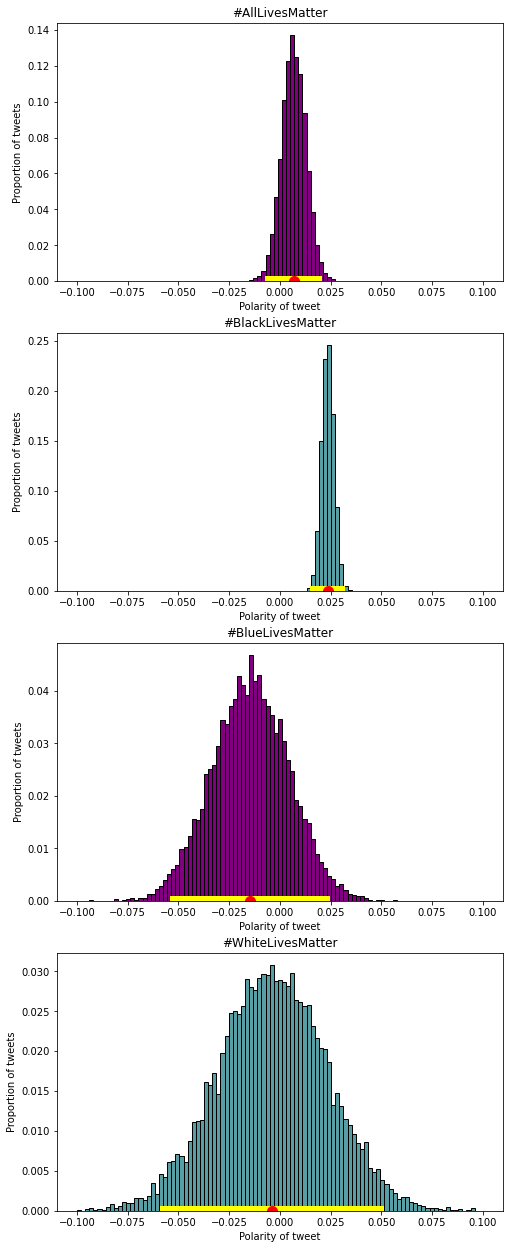

In [ ]:
# For purty visualizations
import matplotlib.pyplot as plt

# Sample polarity means
alm_pol = np.load("data/npy/alm_pol.npy")
blm_pol = np.load("data/npy/blm_pol.npy")
bluelm_pol = np.load("data/npy/bluelm_pol.npy")
wlm_pol = np.load("data/npy/wlm_pol.npy")

# Subset data
alm_data = combined.loc[combined['search'] == "#AllLivesMatter"]
blm_data = combined.loc[combined['search'] == "#BlackLivesMatter"]
bluelm_data = combined.loc[combined['search'] == "#BlueLivesMatter"]
wlm_data = combined.loc[combined['search'] == "#WhiteLivesMatter"]

# Observed test statistics
obs_alm_pol_mean = np.mean(alm_data['polarity'])
obs_blm_pol_mean = np.mean(blm_data['polarity'])
obs_bluelm_pol_mean = np.mean(bluelm_data['polarity'])
obs_wlm_pol_mean = np.mean(wlm_data['polarity'])

fig, axs = plt.subplots(4, 1, figsize=(8,12))
plt.subplots_adjust(top = 1.5)

subsets = [obs_alm_pol_mean,obs_blm_pol_mean,obs_bluelm_pol_mean,obs_wlm_pol_mean]
pols = [alm_pol, blm_pol, bluelm_pol, wlm_pol]
titles = ["#AllLivesMatter", "#BlackLivesMatter", "#BlueLivesMatter", "#WhiteLivesMatter"]
colors = ['purple','#589ea5','purple','#589ea5']

i = 0

for pol,title in zip(pols, titles):
    weights = np.ones_like(pol)/float(len(pol))
    axs[i].hist(pol, color=colors[i], edgecolor='black',weights = weights,bins=np.linspace(-0.1, 0.1, 100), histtype='bar') #histogram
    axs[i].plot(np.percentile(pol,[2.5,97.5]),[0,0],color='yellow',lw=10, zorder=1) #confidence intervals
    axs[i].set_title(title)
    axs[i].set_xlabel('Polarity of tweet')
    axs[i].set_ylabel('Proportion of tweets')
    axs[i].scatter(subsets[i],0.000,color='red',s=100, zorder = 2) #red dot
    i+=1



**B. Now conduct a bootstrap for the difference between the mean polarity score for the #BlackLivesMatter movement and the #BlueLivesMatter movement.**

```
differences = []
for i in np.arange(10000):
    samp = combined.sample(n=10000, replace=True) 
    blm_sample_mean = samp.loc[samp['search'] == "#BlackLivesMatter"]['polarity'].mean()
    bluelm_sample_mean = samp.loc[samp['search'] == "#BlueLivesMatter"]['polarity'].mean()
    difference = blm_sample_mean - bluelm_sample_mean
    differences.append(difference)

np.save('data/npy/differences.npy', differences)
```

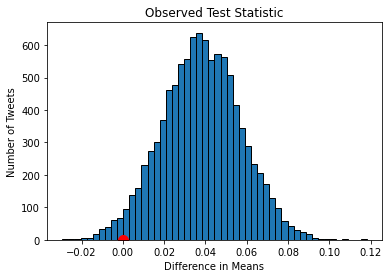

In [ ]:
differences = np.load("/work/data/npy/differences.npy")
plt.hist(differences,bins=50,edgecolor='black')

# Now we need to find out if the difference in the means == 0 is statistically significant - i.e. can we safely assume 
# with the observed data that the null hypothesis holds
plt.scatter(0,0,c='red',s=100,zorder=2)
plt.title('Observed Test Statistic')
plt.xlabel('Difference in Means')
plt.ylabel('Number of Tweets')
plt.show()

**C.** Calculate a p-value. The correct interpretation for the p-value is that you have that % chance of observing the results you obtained, or more extreme, if the null is true.

In [ ]:
import scipy
from scipy import stats


p_value = scipy.stats.norm.sf(abs(0-differences.mean())/differences.std())

print("The calculated p-value is", round(p_value,4), ", therefore there is a 2.24% chance of observing the results we obtained, or more extreme, if the null is true.")

The calculated p-value is 0.0224 , therefore there is a 2.24% chance of observing the results we obtained, or more extreme, if the null is true.


___
#### *Step 5. Interpreting the Results*

**Fill in the blank:** There is a 95% that the true parameter that we want to estimate, which was *\[answer here]*, is within the interval. 

**Answer:** 

A result is statistically significant when the p-value is less than alpha. This signifies a change was detected: that the default hypothesis can be rejected. If p-value > alpha: Fail to reject the null hypothesis (i.e. not significant result). If p-value <= alpha: Reject the null hypothesis (i.e. significant result).

**Answer:** Is our null hypothesis supported or not supported? *\[answer here]*

**In the context of our project:** Does this indicate that BLM had a polarity score equal to, greater than, or lesser than other social movements? What does this polarity score mean? *\[answer here]*

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=10678dc2-c8fa-489c-8ed7-951773803afb' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>